<a href="https://colab.research.google.com/github/elisabethzinck/deep_learning_project/blob/master/Src/Visualization/Evaluate_performance_10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up things

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


In [2]:
! pip install datasets
! pip install transformers

In [3]:
# Import things to get data to work
from datasets import load_from_disk
import sys
import os

# Load data

In [4]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
sys.path.append(os.path.join('/content/drive/My Drive/deep_learning_project'))
#train_path = 'drive/My Drive/deep_learning_project/train_small'
#val_path = 'drive/My Drive/deep_learning_project/validation_small'
val_path = 'drive/My Drive/deep_learning_project/validation_20000'

In [6]:
validation_data = load_from_disk(val_path)

In [7]:
len(validation_data)

16504

In [8]:
print(validation_data[0])

{'answer': 'coventry', 'paragraph': ['[P] england', 'camelot excalibur merlin and the knights of the round table such as lancelot these stories are most centrally brought together within geoffrey of monmouth s historia regum britanniae history of the kings of britain another early figure from british tradition king cole may have been based on a real figure from sub roman britain many of the tales and pseudo histories make up part of the wider matter of britain a collection of shared british folklore some folk figures are based on semi or actual historical people whose story has been passed down centuries lady godiva for instance was said to have ridden naked on horseback through coventry hereward the wake was a heroic english figure resisting the norman invasion herne the hunter is an equestrian ghost associated'], 'question': ['[Q]', 'Where in England was actor Nigel Hawthorne born?'], 'question_id': 'tc_586'}


# Define functions

In [9]:
# Imports required to run functions
import numpy as np
from random import sample
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizerFast, BertModel, AutoTokenizer



def get_top_k(similarity, question_ids, paragraph_ids, k):
    """
    Return the top k documents for based on similarity matrix

    Parameters
    ----------
    similarity : ndarray
        similarity matrix with shape (n_questions, n_paragraphs)
    question_ids : list of str
        List of the question ids
    paragraph_ids : list of str
        List of the paragraph ids (corresponding to the question id that the 
                                   paragraph belongs to)
    k : int
        Number or paragraphs to return

    Returns
    -------
    out : dict
        keys are the question ids, and each element contains list of the ids of the
        k nearest paragraphs
    """
    n_questions = similarity.shape[0]
    idxs = [np.argsort(similarity[row,:])[-k:][::-1] for row in range(n_questions)]
    out = {question_ids[i]:np.array(paragraph_ids)[idxs[i]] for i in range(n_questions)}
    return out

def get_accuracy(top_k):
    """ Returns accuracy. top_k is a dict as returned by get_top_k().  """
    n_correct = [(question in paragraphs) for question, paragraphs in top_k.items()]
    accuracy = sum(n_correct)/len(top_k)*100
    return accuracy


def get_tfidf_similarity(questions, paragraphs):
    """
    Returns a similarity matrix based on the distance in the tf-idf space

    Parameters
    ----------
    questions : list of strings
        Lists of all questions.
    paragraphs : list of strings
        Lists of all paragraphs
    
    Returns :
    -------
        Similarity matrix of dimension  
        (number of questions, number of paragraphs). 
    """
    vectorizer = TfidfVectorizer(lowercase = False)
    all_text = questions + paragraphs
    vectorizer.fit(all_text)
    similarity = vectorizer.transform(questions) * vectorizer.transform(paragraphs).T
    return np.array(similarity.todense())

def get_random_accuracy(k_list, n):
    max_k = max(k_list)
    top_k_list = [sample(range(n), max_k) for i in range(n)] # 
    accs = [None]*len(k_list)
    for i, k in enumerate(k_list): 
        n_correct = [(1 in top_k[0:k]) for top_k in top_k_list]
        accs[i] = sum(n_correct)/n*100
    return(accs)

def get_accuracy_vector(k_list, sim, question_ids, paragraph_ids):
    accs = [None]*len(k_list)
    for i, k in enumerate(k_list):
        top_k = get_top_k(sim, question_ids, paragraph_ids, k)
        accs[i] = get_accuracy(top_k)
    return accs



In [63]:
def get_BERT_similarity(data, tokenizer_name = 'bert-base-uncased', finetuned = False, model_name = 'bert-base-uncased'):
    """
    Returns a similarity matrix based on the distance in the BERT encoded space

    Parameters
    ----------
    questions : list of strings
        Lists of all questions.
    paragraphs : list of strings
        Lists of all paragraphs
    tokenizer_name : string
        What tokenizer to use. Options = ['bert-base-uncased', 'bert-large-uncased']
    finetuned : bool
        Whether to use models that we have finetuned or not
    model_name : string
        Name of model to use. Options = ['bert-base-uncased', 'bert-large-uncased', ']
    
    Returns :
    -------
        Similarity matrix of dimension  
        (number of questions, number of paragraphs). 
    """
    # Define tokenizer 
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, padding = True)

    # Define model
    if finetuned:
      folder_path = 'drive/My Drive/deep_learning_project/Fine-tuned BERT models/'
      model_path = folder_path + model_name
      model = BertModel.from_pretrained(model_path)
    else:
      model = BertModel.from_pretrained(model_name)
    
    model.to(device)
    batch_size = 16
    n_batch_print = 16
    
    # Tokenize data
    tokenized_data = data.map(lambda example: {
    'Q_input_ids': tokenizer(example['question'],padding = 'longest')['input_ids'],
    'Q_attention_mask': tokenizer(example['question'], padding = 'longest')['attention_mask'],
    'Q_token_type_ids': tokenizer(example['question'], padding = 'longest')['token_type_ids'],
    'P_input_ids': tokenizer(example['paragraph'],  padding = 'longest')['input_ids'],
    'P_attention_mask': tokenizer(example['paragraph'],  padding = 'longest')['attention_mask'],
    'P_token_type_ids': tokenizer(example['paragraph'],  padding = 'longest')['token_type_ids']},
    batched = True, batch_size= batch_size)

    tokenized_data.set_format(type = 'torch', 
                        columns = ['Q_input_ids', 'Q_attention_mask', 'Q_token_type_ids',
                                   'P_input_ids', 'P_attention_mask', 'P_token_type_ids'])
    dataloader = torch.utils.data.DataLoader(tokenized_data, batch_size=batch_size)
    dataloader = iter(dataloader)

    # Save encoded layers
    n_batches = len(dataloader)
    P_encoded_layers_list = [None]*n_batches
    Q_encoded_layers_list = [None]*n_batches

    
    with torch.no_grad():
      for i, batch in enumerate(dataloader):
        if i % n_batch_print == 0:
          print(f'batch {i+1}/{len(dataloader)}')

        # Make forward pass for paragraphs
        input_ids = batch['P_input_ids'].to(device)
        attention_mask = batch['P_attention_mask'].to(device)
        token_type_ids = batch['P_token_type_ids'].to(device)
        if model_name == '91011layer-trained_on_train' or model_name == 'BERT_ablation_9thTo11th':
          P_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)
          P_encoded_layers_list[i] = torch.cat(tuple([P_encoded_layers.hidden_states[j] for j in [-3, -2, -1]]), dim=-1)[:, 0, :]
        else:
          P_encoded_layers_list[i] = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)[0][:, 0, :]
        
        # Make forward pass for questions
        input_ids = batch['Q_input_ids'].to(device)
        attention_mask = batch['Q_attention_mask'].to(device)
        token_type_ids = batch['Q_token_type_ids'].to(device)
        if model_name == '91011layer-trained_on_train' or model_name == 'BERT_ablation_9thTo11th':
          Q_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)
          Q_encoded_layers_list[i] = torch.cat(tuple([Q_encoded_layers.hidden_states[j] for j in [-3, -2, -1]]), dim=-1)[:, 0, :]
        else:
          Q_encoded_layers_list[i] = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)[0][:, 0, :]

    # Save encoded layers
    P_encoded_layers = torch.cat(P_encoded_layers_list, dim = 0)
    Q_encoded_layers = torch.cat(Q_encoded_layers_list, dim = 0)

    # Get similarity
    sim = torch.matmul(Q_encoded_layers, P_encoded_layers.T).cpu().numpy()

    return sim
  

## Calculate similarity matrices

In [59]:
k_list = [i+1 for i in range(256)]

In [64]:
data = validation_data # Using all data  where the problems were before: (.select(range(226*16,229*16)))
data = data.filter(lambda example: example['question_id'] != 'qw_6952') # Removing one paragraph with a bunch of russian

#%% Define inputs
questions_BERT = data['question']
question_ids = data['question_id']
paragraphs_BERT = data['paragraph']
#%%
questions = [entry[0] + ' ' + entry[1] for entry in questions_BERT]
paragraphs = [entry[0] + ' ' + entry[1] for entry in paragraphs_BERT]

In [65]:
sim_tfidf = get_tfidf_similarity(questions, paragraphs)


In [66]:
# Default base model (no finetuning)
sim_BERT = get_BERT_similarity(data)


batch 1/1032
batch 17/1032
batch 33/1032
batch 49/1032
batch 65/1032
batch 81/1032
batch 97/1032
batch 113/1032
batch 129/1032
batch 145/1032
batch 161/1032
batch 177/1032
batch 193/1032
batch 209/1032
batch 225/1032
batch 241/1032
batch 257/1032
batch 273/1032
batch 289/1032
batch 305/1032
batch 321/1032
batch 337/1032
batch 353/1032
batch 369/1032
batch 385/1032
batch 401/1032
batch 417/1032
batch 433/1032
batch 449/1032
batch 465/1032
batch 481/1032
batch 497/1032
batch 513/1032
batch 529/1032


RuntimeError: ignored

In [ ]:
# 11th layer finetuned
sim_BERT_finetuned_train = get_BERT_similarity(data, finetuned = True, model_name = '11layer-trained_on_train')

In [ ]:
# 9-11th layer finetuned
sim_BERT_finetuned_91011 = get_BERT_similarity(data, finetuned = True, model_name = '91011layer-trained_on_train')

## Get accuracies

In [ ]:
#%% Get accuracies for a range of ks
acc_tfidf = get_accuracy_vector(k_list, sim_tfidf, question_ids, question_ids)
acc_bert = get_accuracy_vector(k_list, sim_BERT, question_ids, question_ids)
acc_bert_finedtuned_train = get_accuracy_vector(k_list, sim_BERT_finetuned_train, question_ids, question_ids)
acc_bert_finedtuned_91011 = get_accuracy_vector(k_list, sim_BERT_finetuned_91011, question_ids, question_ids)
acc_bert_ablation_11th = get_accuracy_vector(k_list, sim_BERT_ablation_11th, question_ids, question_ids)
acc_bert_ablation_9thTo11th = get_accuracy_vector(k_list, sim_BERT_ablation_9thTo11th, question_ids, question_ids)
acc_random = get_random_accuracy(k_list, n)

## Plot accuracies

In [ ]:
from matplotlib import pyplot as plt

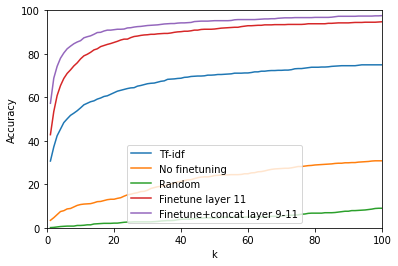

In [ ]:
fig = plt.figure()
plt.plot(k_list, acc_tfidf, label = 'Tf-idf')
plt.plot(k_list, acc_bert, label = 'No finetuning')
plt.plot(k_list, acc_random, label = 'Random')
plt.plot(k_list, acc_bert_finedtuned_train, label = 'Finetune layer 11')
plt.plot(k_list, acc_bert_finedtuned_91011, label = 'Finetune+concat layer 9-11')
plt.ylim((0,100))
plt.xlim((0,100))
plt.legend(loc = 'lower center')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()
fig.savefig("drive/My Drive/deep_learning_project/figures/accuracy_curves.pdf", bbox_inches='tight')

## Save accuracies to csv

In [ ]:
import pandas as pd

In [ ]:
all_accuracies = pd.DataFrame(list(zip(k_list, acc_random, acc_tfidf, acc_bert, acc_bert_finedtuned_train, acc_bert_finedtuned_91011, acc_bert_ablation_11th, acc_bert_ablation_9thTo11th)), 
                              columns = ['k', 'random', 'tfidf', 'no_finetune', 'finetuned_11th', 'finetuned_9thTo11th', 'ablation_11th', 'ablation_9thTo11th'])

In [ ]:
all_accuracies

,k,random,tfidf,no_finetune,finetuned_11th,finetuned_9thTo11th,ablation_11th,ablation_9thTo11th
0,1,0.097656,30.707071,3.434343,42.828283,57.272727,23.535354,11.313131
1,2,0.195312,37.171717,4.646465,53.434343,68.787879,32.828283,15.656566
2,3,0.390625,42.323232,6.060606,60.808081,74.242424,37.575758,19.090909
3,4,0.585938,45.353535,7.474747,65.353535,77.979798,41.414141,22.222222
4,5,0.683594,48.383838,7.878788,68.686869,80.404040,43.333333,25.050505
...,...,...,...,...,...,...,...,...
251,252,22.949219,80.707071,48.686869,98.080808,99.494949,87.878788,79.393939
252,253,23.046875,80.808081,49.090909,98.080808,99.494949,87.979798,79.494949
253,254,23.046875,80.808081,49.292929,98.080808,99.494949,87.979798,79.595960
254,255,23.242188,80.808081,49.393939,98.080808,99.494949,87.979798,79.595960


In [ ]:
all_accuracies.to_csv('drive/My Drive/deep_learning_project/tables/all_accuracies.csv')

## Create table for report

In [ ]:
from tabulate import tabulate

In [ ]:
report_df = all_accuracies.copy()
report_df = report_df[report_df.k.isin([5,20,100])]
report_df = report_df.set_index('k')
report_df = report_df[['no_finetune', 'finetuned_11th', 'finetuned_9thTo11th', 'ablation_11th', 'ablation_9thTo11th']]
report_df = report_df.transpose()
report_df

k,5,20,100
no_finetune,7.878788,13.131313,30.808081
finetuned_11th,68.686869,85.252525,94.747475
finetuned_9thTo11th,80.404040,91.111111,97.575758
ablation_11th,43.333333,60.202020,78.787879
ablation_9thTo11th,25.050505,41.717172,63.333333


In [ ]:
print(tabulate(report_df, tablefmt = 'latex', floatfmt=".2f", headers = ['Model', 'Top-5', 'Top-20', 'Top-100']))

\begin{tabular}{lrrr}
\hline
 Model               &   Top-5 &   Top-20 &   Top-100 \\
\hline
 no\_finetune         &    7.88 &    13.13 &     30.81 \\
 finetuned\_11th      &   68.69 &    85.25 &     94.75 \\
 finetuned\_9thTo11th &   80.40 &    91.11 &     97.58 \\
 ablation\_11th       &   43.33 &    60.20 &     78.79 \\
 ablation\_9thTo11th  &   25.05 &    41.72 &     63.33 \\
\hline
\end{tabular}


## Look at similarity matrices

<Figure size 432x288 with 0 Axes>

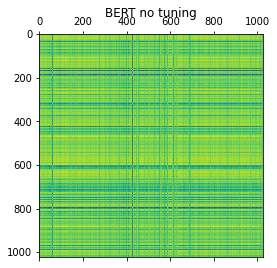

<Figure size 432x288 with 0 Axes>

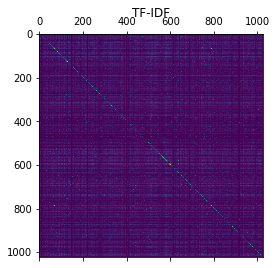

<Figure size 432x288 with 0 Axes>

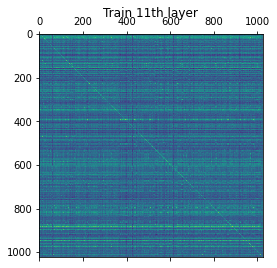

<Figure size 432x288 with 0 Axes>

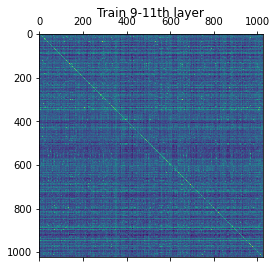

In [ ]:
fig = plt.figure()
plt.matshow(sim_BERT)
plt.title('BERT no tuning')
plt.show()
#plt.imsave()
#plt.savefig("drive/My Drive/deep_learning_project/figures/nofinetune_simmatrix.pdf", bbox_inches='tight')

fig = plt.figure()
plt.matshow(tfidf_sim)
plt.title('TF-IDF')
plt.show()
#plt.savefig("drive/My Drive/deep_learning_project/figures/tfidf_simmatrix.pdf", bbox_inches='tight')

fig = plt.figure()
plt.matshow(sim_BERT_finetuned_train)
plt.title('Train 11th layer')
plt.show()
#plt.savefig("drive/My Drive/deep_learning_project/figures/layer11_simmatrix.pdf", bbox_inches='tight')

fig = plt.figure()
plt.matshow(sim_BERT_finetuned_91011)
plt.title('Train 9-11th layer')
plt.show()
#plt.savefig("drive/My Drive/deep_learning_project/figures/concat_simmatrix.pdf", bbox_inches='tight')


In [ ]:
data['paragraph'][225*16: 240*16]

[['[P] hasmonean dynasty',
  'central government he appears to have controlled the road from jaffa to jerusalem and thus to have cut off the royal party in acra from direct communication with the sea and thus with the government it is significant that this time the syrian troops under the leadership of the governor general lysias took the southerly route by way of idumea in 164 bce judah captured jerusalem and the temple in jerusalem was freed and reconsecrated after having recovered jerusalem judah ordered the temple to be cleansed a new altar to be built in place of the desecrated one and new holy vessels to be made the celebratory festival of hanukkah is instituted when the fire had been kindled anew upon the altar and the lamps of the candlestick'],
 ['[P] taiwan',
  'mountains running in five ranges from the northern to the southern tip of the island and the flat to gently rolling chianan plains in the west that are also home to most of taiwan s population taiwan s highest point i